In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
# Please refer to requirements.txt for a full list of all libraries and their versions used in this project.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# Setting random seeds to reduce the amount of randomness in the neural net weights and results.
# The results may still not be exactly reproducible.
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Checking the installed version of TensorFlow.
# The code in this notebook was written using TensorFlow version 2.2.0.

tf.__version__

'2.12.0'

In [ ]:
# Importing the table showing the breakdown of age-ranges into classes.

combined_classes = pd.read_csv("/content/drive/MyDrive/NNDL project/combined_faces_classes_summary.csv")
combined_classes

,Class label,Age-ranges (classes),No. of images,Class balance (%)
0,0,1 - 1,2235,8.35
1,1,2 - 5,2439,9.11
2,2,6 - 16,2463,9.20
3,3,17 - 24,2828,10.56
4,4,25 - 26,2931,10.95
5,5,27 - 30,2827,10.56
6,6,31 - 35,2446,9.14
7,7,36 - 42,2291,8.56
8,8,43 - 53,2313,8.64
9,9,54 - 65,2298,8.58


In [ ]:
# Importing the training and testing datasets to create tensors of images using the filename paths.

train_df = pd.read_csv("/content/drive/MyDrive/NNDL project/images_filenames_labels_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/NNDL project/images_filenames_labels_test.csv")

In [ ]:
train_df.head()

,filename,age,target
0,/content/content/combined_faces/25_730.jpg,25,3
1,/content/content/combined_faces/34_218.jpg,34,6
2,/content/content/combined_faces/26_791.jpg,26,4
3,/content/content/combined_faces/24_710.jpg,24,3
4,/content/content/combined_faces/49_78.jpg,49,8


In [ ]:
test_df.head()

,filename,age,target
0,/content/content/combined_faces/30_442.jpg,30,5
1,/content/content/combined_faces/36_112.jpg,36,6
2,/content/content/combined_faces/31_105.jpg,31,5
3,/content/content/combined_faces/28_514.jpg,28,5
4,/content/content/combined_faces/58_52.jpg,58,9


In [ ]:
train_df.shape

(18739, 3)

In [ ]:
test_df.shape

(8031, 3)

In [ ]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(train_df['filename'])
train_labels_list = list(train_df['target'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

In [ ]:
# Creating tensorflow constants of filenames and labels for train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Defining the number of classes and a function to read, decode the image from given tensor and one-hot encode the image label class.

num_classes = 11

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3;RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(3)
train_dataset = train_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

cnn with regularization

In [ ]:
from tensorflow.keras.regularizers import l1, l2

cnn2 = Sequential()

cnn2.add(Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=(200, 200, 1), kernel_regularizer=l2(0.01)))
cnn2.add(Conv2D(filters=16, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
cnn2.add(Conv2D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
cnn2.add(MaxPooling2D(pool_size=(2,2)))

cnn2.add(Conv2D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
cnn2.add(MaxPooling2D(pool_size=(2,2)))

cnn2.add(Conv2D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
cnn2.add(MaxPooling2D(pool_size=(2,2)))

cnn2.add(GlobalAveragePooling2D())
cnn2.add(Dense(20, activation='relu', kernel_regularizer=l2(0.01)))
cnn2.add(Dense(11, activation='softmax', kernel_regularizer=l2(0.01)))

cnn2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 198, 198, 8)       80        
                                                                 
 conv2d_4 (Conv2D)           (None, 196, 196, 16)      1168      
                                                                 
 conv2d_5 (Conv2D)           (None, 194, 194, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 97, 97, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 95, 95, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                  

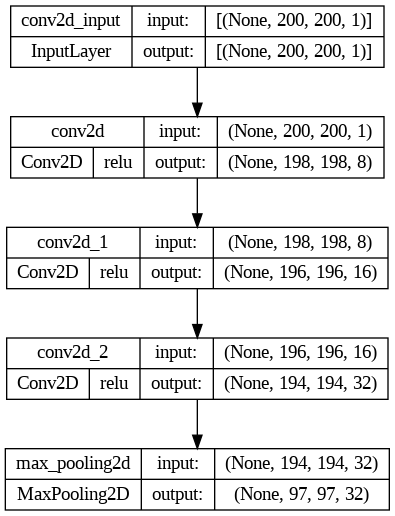

In [ ]:
tf.keras.utils.plot_model(
    cnn1,
    to_file='/content/drive/MyDrive/UTKFace/UTKFace/model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

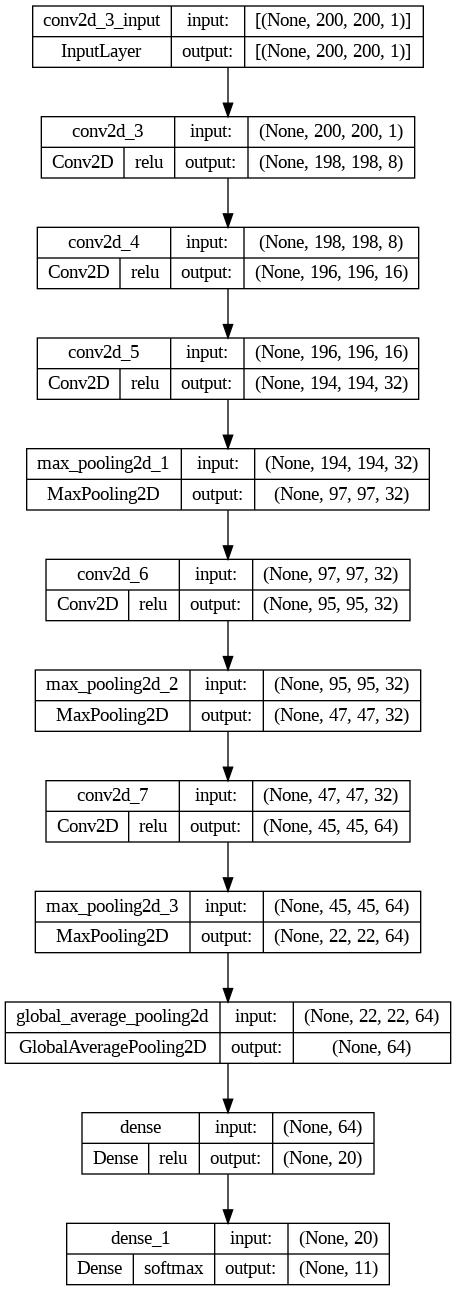

In [ ]:
tf.keras.utils.plot_model(
    cnn2,
    to_file='/content/drive/MyDrive/UTKFace/UTKFace/model1.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

In [ ]:
# Compiling the neural network defined above.
cnn1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Defining the early stop to monitor the validation loss to avoid overfitting.
#using "earlystopping" to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adagrad

In [ ]:
opt = Adagrad(learning_rate=0.01)
cnn2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
x_train = train_df.reshape(-1, 28, 28, 1) / 255.0
x_test = test_.reshape(-1, 28, 28, 1) / 255.0
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

cnn2.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

TypeError: ignored

In [ ]:
# Fitting the model.

cnn1_history = cnn1.fit(train_dataset,
                        batch_size=512,
                        validation_data=test_dataset,
                        epochs=10,
                        callbacks=[early_stop],
                        shuffle=False    
                       )

Epoch 1/10


ValueError: ignored

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss1 = cnn1_history.history['loss']
test_loss1 = cnn1_history.history['val_loss']
train_accuracy1 = cnn1_history.history['accuracy']
test_accuracy1 = cnn1_history.history['val_accuracy']

NameError: ignored

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss1, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss1, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy1, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy1, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs (using grayscale images)", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Age_Classification_with_Faces/plot_images/cnn1_loss_accuracy.png', bbox_inches='tight');

In [ ]:
# Evaluating the model on test dataset.

cnn2_score = cnn1.evaluate(test_dataset, verbose=1)

In [ ]:
# Printing the relevant score summary.
cnn2_labels = cnn1.metrics_names
print(f'CNN_1 model {cnn1_labels[0]} \t= {round(cnn1_score[0], 3)}')
print(f'CNN_1 model {cnn1_labels[1]} \t= {round(cnn1_score[1], 3)}')

In [ ]:
# Saving the model as a h5 file for possible use later.

cnn2.save(f"/content/drive/My Drive/Age_Classification_with_Faces/input_output/cnn1_model_acc_{round(cnn1_score[1], 3)}.h5", save_format='h5')

In [ ]:
# Generating predictions from the model above.

cnn1_pred = cnn1.predict(test_dataset)
cnn1_pred = cnn1_pred.argmax(axis=-1)

In [ ]:
len(cnn2_pred)

In [ ]:
len(test_labels_list)

In [ ]:
# Generating a confusion matrix based on above predictions.

conf_mat1 = confusion_matrix(test_labels_list, cnn2_pred)
conf_mat1

In [ ]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/My Drive/Age_Classification_with_Faces/plot_images/{export_as}.png', bbox_inches='tight');

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = combined_classes['Age-ranges (classes)']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat1, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN_1 model",
                      export_as="cnn1_conf_mat_norm"
                     )

plt.show()

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = combined_classes['Age-ranges (classes)']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat1, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from CNN_1 model",
                      export_as="cnn1_conf_mat"
                     )

plt.show()

In [ ]:
# Creating a new dataframe to store all the CNN models summary scores.

cnn_summary_df = pd.DataFrame(columns=['Model Description', 'Train Loss', 'Val Loss', 'Train Accuracy', 'Val Accuracy'])

In [ ]:
# Creating and saving the summary dataframe with the above model scores.

cnn_summary_df.loc[1] = {'Model Description' : 'CNN with grayscale images; 28 epochs',
                         'Train Loss' : round(train_loss1[-1], 4),
                         'Val Loss' : round(test_loss1[-1], 4),
                         'Train Accuracy' : round(train_accuracy1[-1], 4),
                         'Val Accuracy' : round(test_accuracy1[-1], 4)
                        }

cnn_summary_df.to_csv("/content/drive/My Drive/Age_Classification_with_Faces/input_output/cnn_models_summary.csv", index=False)
cnn_summary_df

In [ ]:
# Defining a function to return the class labels corresponding to the age-ranges shown above.

def class_labels_reassign(age):

    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

In [ ]:
train_df.head()

In [ ]:
train_aug_df.head()

In [ ]:
test_df.head()

In [ ]:
train_df['target_reassign'] = train_df['age'].map(class_labels_reassign)
train_aug_df['target_reassign'] = train_aug_df['age'].map(class_labels_reassign)
test_df['target_reassign'] = test_df['age'].map(class_labels_reassign)

In [ ]:
train_df.head()

In [ ]:
train_aug_df.head()

In [ ]:
test_df.head()

In [ ]:
train_df['target_reassign'].value_counts(normalize=True)

In [ ]:
train_aug_df['target_reassign'].value_counts(normalize=True)

In [ ]:
test_df['target_reassign'].value_counts(normalize=True)

In [ ]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(train_df['filename'])
train_labels_list = list(train_df['target_reassign'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target_reassign'])

In [ ]:
# Creating tensorflow constants of filenames and labels for train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Redefining the function to read, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(3)
train_dataset = train_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# Defining the architecture of the sequential neural network.

cnn4 = Sequential()

cnn4.add(Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
cnn4.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
cnn4.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn4.add(MaxPooling2D(pool_size=(2,2)))

cnn4.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn4.add(MaxPooling2D(pool_size=(2,2)))

cnn4.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn4.add(MaxPooling2D(pool_size=(2,2)))

cnn4.add(GlobalAveragePooling2D())

cnn4.add(Dense(20, activation='relu'))
cnn4.add(Dense(7, activation='softmax'))    # No. of nodes in output layer changed from 11 to 7 for the re-distributed age-range classes.

cnn4.summary()

In [ ]:
# Compiling the neural network defined above.

cnn4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Fitting the model.

cnn4_history = cnn4.fit(train_dataset,
                        batch_size=512,
                        validation_data=test_dataset,
                        epochs=30,
                        callbacks=[early_stop],
                        shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                       )

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss4 = cnn4_history.history['loss']
test_loss4 = cnn4_history.history['val_loss']
train_accuracy4 = cnn4_history.history['accuracy']
test_accuracy4 = cnn4_history.history['val_accuracy']

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss4, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss4, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy4, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy4, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.96, t="Lineplots showing loss and accuracy of CNN model by epochs\n(using grayscale images and re-distributed age-range classes)", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Age_Classification_with_Faces/plot_images/cnn4_loss_accuracy.png', bbox_inches='tight');

In [ ]:
# Evaluating the model on test dataset.

cnn4_score = cnn4.evaluate(test_dataset, verbose=1)

In [ ]:
# Printing the relevant score summary.

cnn4_labels = cnn4.metrics_names

print(f'CNN_1 model {cnn1_labels[0]} \t= {round(cnn1_score[0], 3)}')
print(f'CNN_1 model {cnn1_labels[1]} \t= {round(cnn1_score[1], 3)}')
print()
print(f'CNN_2 model {cnn2_labels[0]} \t= {round(cnn2_score[0], 3)}')
print(f'CNN_2 model {cnn2_labels[1]} \t= {round(cnn2_score[1], 3)}')
print()
print(f'CNN_3 model {cnn3_labels[0]} \t= {round(cnn3_score[0], 3)}')
print(f'CNN_3 model {cnn3_labels[1]} \t= {round(cnn3_score[1], 3)}')
print()
print(f'CNN_3 model {cnn3_labels[0]} \t= {round(cnn3_1_score[0], 3)}')
print(f'CNN_3 model {cnn3_labels[1]} \t= {round(cnn3_1_score[1], 3)}')
print()
print(f'CNN_4 model {cnn4_labels[0]} \t= {round(cnn4_score[0], 3)}')
print(f'CNN_4 model {cnn4_labels[1]} \t= {round(cnn4_score[1], 3)}')

In [ ]:
# Saving the model as a h5 file for possible use later.

cnn4.save(f"/content/drive/My Drive/Age_Classification_with_Faces/input_output/cnn4_model_acc_{round(cnn4_score[1], 3)}.h5", save_format='h5')

In [ ]:
# Generating predictions from the model above.

cnn4_pred = cnn4.predict(test_dataset)
cnn4_pred = cnn4_pred.argmax(axis=-1)

In [ ]:
len(cnn4_pred)

In [ ]:
len(test_labels_list)

In [ ]:
# Generating a confusion matrix based on above predictions.

conf_mat4 = confusion_matrix(test_labels_list, cnn4_pred)
conf_mat4

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat4, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN_4 model",
                      export_as="cnn4_conf_mat_norm"
                     )

plt.show()

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat4, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from CNN_4 model",
                      export_as="cnn4_conf_mat"
                     )

plt.show()

In [ ]:
# Creating and saving the summary dataframe with the above model scores.

cnn_summary_df.loc[5] = {'Model Description' : 'CNN with grayscale images; Re-distributed age-ranges; 30 epochs',
                         'Train Loss' : round(train_loss4[-1], 4),
                         'Val Loss' : round(test_loss4[-1], 4),
                         'Train Accuracy' : round(train_accuracy4[-1], 4),
                         'Val Accuracy' : round(test_accuracy4[-1], 4)
                        }

cnn_summary_df.to_csv("/content/drive/My Drive/Age_Classification_with_Faces/input_output/cnn_models_summary.csv", index=False)
cnn_summary_df

In [ ]:
train_df.head()

NameError: ignored

In [ ]:
test_df.head()

In [ ]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(train_df['filename'])
train_labels_list = list(train_df['target_reassign'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target_reassign'])

In [ ]:
# Creating tensorflow constants of filenames and labels for train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Redefining the function to read, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(2)
train_dataset = train_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# Defining the numbers of Conv2D layers, Dense layers and types of Pooling2D layers for the optimization loop to run through. 

conv_layers = [1, 2, 3]
dense_layers = [0, 1, 2]
pooling = ['max', 'avg']    # Changing the pooling layers from MaxPooling2D to AveragePooling2D may have an impact on accuracy values as well. This will be tested here in this optimization process.

In [ ]:


model_counter = 0

for conv in conv_layers:
    for dense in dense_layers:
        for pool in pooling:
            
            model_counter += 1
            cur_time = datetime.fromtimestamp(time.time()).strftime('%Y%m%d%H%M%S')
            model_name = f"cnn_{str(conv)}-conv_{str(dense)}-dense_{pool}-pool_{cur_time}"

            print(f"\n\nTRAINING MODEL {model_counter} OF 18 : {model_name}\n")

            tensorboard = TensorBoard(log_dir=f"/content/drive/My Drive/Age_Classification_with_Faces/input_output/cnn_logs/{model_name}")

            cnn = Sequential()

            cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    
            if pool=='max':
                cnn.add(MaxPooling2D(pool_size=(2,2)))
            elif pool=='avg':
                cnn.add(AveragePooling2D(pool_size=(2,2)))
          
            conv_filters = 32
            for c in range(conv):
                conv_filters *= 2
                cnn.add(Conv2D(filters=conv_filters, kernel_size=3, activation='relu'))
                if pool=='max':
                    cnn.add(MaxPooling2D(pool_size=(2,2)))
                elif pool=='avg':
                    cnn.add(AveragePooling2D(pool_size=(2,2)))

            cnn.add(GlobalAveragePooling2D())

  
            dense_nodes = int((conv_filters - 7) / (dense + 1))
            for d in range(dense):
                nodes = conv_filters - ((d+1) * dense_nodes)
                cnn.add(Dense(nodes, activation='relu'))
            
            cnn.add(Dense(7, activation='softmax'))
            
            cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

            cnn.fit(train_dataset,
                    batch_size=512,
                    validation_data=test_dataset,
                    epochs=25,
                    callbacks=[early_stop, tensorboard],
                    shuffle=False    
                   )
            
            cnn.save(f"/content/drive/My Drive/Age_Classification_with_Faces/input_output/cnn_logs/{model_name}.h5", save_format='h5')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=/content/drive/My\ Drive/Age_Classification_with_Faces/input_output/cnn_logs